In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [8]:
%%writefile react_agent01.py

from dotenv import load_dotenv
load_dotenv()

from tavilytool import tool as tavilyTool
# Exercise: can add more tools here later
# TODO: add some tools from MCP here

tools = [tavilyTool]


from langchain.chat_models import init_chat_model

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)


import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

Writing react_agent01.py


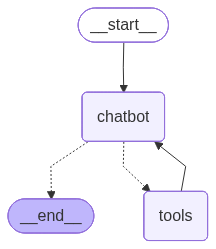

In [9]:
from react_agent01 import graph

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: [{'text': "I apologize, but I don't have a direct way to get today's current date. Let me search for current date information.", 'type': 'text'}, {'id': 'toolu_01BkECxXHmXvAs7ppcN7Amjt', 'input': {'query': "what is today's current date", 'time_range': 'day'}, 'name': 'tavily_search', 'type': 'tool_use'}]
Assistant: {"query": "what is today's current date", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://date-today.com/en/", "title": "What Is Today's Date", "content": "Today's date in gregorian ; Gregorian calendar, 21 October 2025 ; Gregorian calendar, Digital format, 21/10/2025 ; Year type, 2025 Is not a leap year ; Julian date", "score": 0.79901963, "raw_content": null}, {"url": "https://www.rapidtables.com/tools/todays-date.html", "title": "Today's Date | Current date now - RapidTables.com", "content": "This page includes the following information: Today's date: day of week, month, day, year. Current time: hours, minutes, seconds.",